# Imports

In [1]:
## Import libraries 
## Data manipulation 
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify
%matplotlib inline

## Data processing, metrics and modeling
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, f1_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import DiscriminationThreshold


# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# SMOTH 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

##ignore warning messages 
#import warnings
#warnings.filterwarnings('ignore') 


In [2]:
## Import data
df = pd.read_csv("Data/diab_ckd_data.csv")

# Create target columns

In [3]:
#Target columns (Dependent variables 1,2 and 3)
DV1Filter = (df.TIME_CRF<=2) & (df.EVENT_CRF==1)
DV2Filter = (df.TIME_CRF<=5) & (df.EVENT_CRF==1)
DV3Filter = (df.TIME_CRF<=10) & (df.EVENT_CRF==1)
df["DV1"] = DV1Filter.astype(int)
df["DV2"] = DV2Filter.astype(int)
df["DV3"] = DV3Filter.astype(int)
# df.head()

# Spliting data (train and test)

In [4]:
## Split data
from sklearn.model_selection import train_test_split
df, df_test = train_test_split(df,test_size=0.20,random_state=0,
                                                    stratify=df["DV1"])

# Preprocessing data

In [5]:
## Create copy of data frames
X = df.copy()
X_test = df_test.copy()

### Encoding of categorical data

In [6]:
## Encoding categorical data ("SES_GROUP" and "MIGZAR")
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelEncoder = LabelEncoder()

# ## change to one hot encoding
# labelEncoder.fit(df["SES_GROUP"])
# X["SES_GROUP"] = labelEncoder.transform(df["SES_GROUP"])
# X_test["SES_GROUP"] = labelEncoder.transform(df_test["SES_GROUP"])

OH_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
SES_col = list(df["SES_GROUP"].unique())
OH_X = OH_encoder.fit_transform(df["SES_GROUP"].values.reshape(-1,1)) 
OH_X = pd.DataFrame(OH_X, columns=SES_col)
OH_X_test = OH_encoder.transform(X_test["SES_GROUP"].values.reshape(-1,1)) 
OH_X_test = pd.DataFrame(OH_X_test, columns=SES_col)
#Drop SES column and add OH SES columns to X
X.drop(["SES_GROUP"], axis=1, inplace=True)
X_test.drop(["SES_GROUP"], axis=1, inplace=True)
X.index= OH_X.index
X_test.index= OH_X_test.index
X = pd.concat([X, OH_X], axis=1)
X_test = pd.concat([X_test, OH_X_test], axis=1)
X.drop(["OTHER"], axis=1, inplace=True)
X_test.drop(["OTHER"], axis=1, inplace=True)

OH_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
MIGZAR_col = list(df["MIGZAR"].unique())
OH_X = OH_encoder.fit_transform(df["MIGZAR"].values.reshape(-1,1)) 
OH_X = pd.DataFrame(OH_X, columns=MIGZAR_col)
OH_X_test = OH_encoder.transform(X_test["MIGZAR"].values.reshape(-1,1)) 
OH_X_test = pd.DataFrame(OH_X_test, columns=MIGZAR_col)
#Drop Migzar column and add OH Migzar columns to X
X.drop(["MIGZAR"], axis=1, inplace=True)
X_test.drop(["MIGZAR"], axis=1, inplace=True)
X.index= OH_X.index
X_test.index= OH_X_test.index
X = pd.concat([X, OH_X], axis=1)
X_test = pd.concat([X_test, OH_X_test], axis=1)

### Split data frame to Features (X) and Target (y)

In [7]:
## Split to Features and target columns
## Drop unrelevent columns
y = X["DV1"]
X.drop(["IDS", "TIME_CRF", "EVENT_CRF","DV1", "DV2","DV3", "AGE_GROUP", "GENERAL"], axis=1, inplace=True)
y_test = X_test["DV1"]
X_test.drop(["IDS", "TIME_CRF", "EVENT_CRF","DV1", "DV2","DV3", "AGE_GROUP", "GENERAL"], axis=1, inplace=True)

## Missing values


Number of columns with missing data: 28


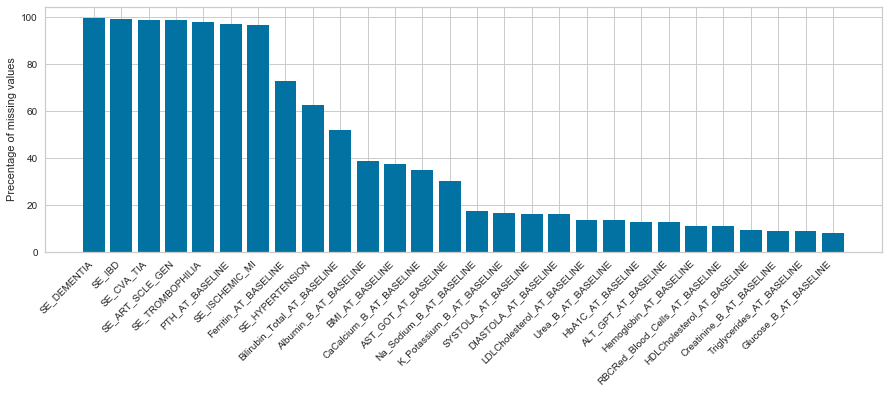

In [8]:
## Missing values
null_df = X.isnull().sum() * 100 / len(df)
null_df.sort_values(ascending=False, inplace=True)
null_df = null_df[null_df.values!=0] # Removing columns without missing values
fig, ax = plt.subplots(figsize= (15,5))
plt.style.use("seaborn")
ax.bar(null_df.index, null_df.values)
fig.autofmt_xdate(rotation=45)
ax.set_ylabel("Precentage of missing values")
print("Number of columns with missing data: {}".format(null_df.size))
plt.show()

### SE and IS columns
Turn SE column to categorical column  
Delete IS columns

In [9]:
## Function- convert SE columns to categorical data
def convertSEs2categories(value):
  if(np.isnan(value)): 
    return 4
  if(value <= SE_25Quant):
    return 1
  elif(value <= SE_75Quant):
    return 2
  else:
    return 3

for element in df.columns: 
  if ((element[0:3] == 'SE_')or(element == 'PTH_AT_BASELINE') or 
      (element == 'Ferritin_AT_BASELINE') or 
      (element == 'Bilirubin_Total_AT_BASELINE') or 
      (element == 'Albumin_B_AT_BASELINE') or 
      (element == 'CaCalcium_B_AT_BASELINE') ):
    # SE_columns.append(element)
    SE_25Quant = df.loc[df["DV1"]==0,element].quantile(q = 0.25)
    SE_75Quant = df.loc[df["DV1"]==0,element].quantile(q = 0.75)
    X[element] = X[element].apply(lambda x: convertSEs2categories(x))
    X_test[element] = X_test[element].apply(lambda x: convertSEs2categories(x))
    #print(X[element].value_counts())

  else:
    pass


In [10]:
## Deleting IS columns
for element in df.columns: 
  if (element[0:3] == 'IS_'):
    if(element=='IS_MALE'):
        pass
    else:
        X.drop([element], axis=1, inplace=True)
        X_test.drop([element], axis=1, inplace=True)

Number of columns with missing data: 16


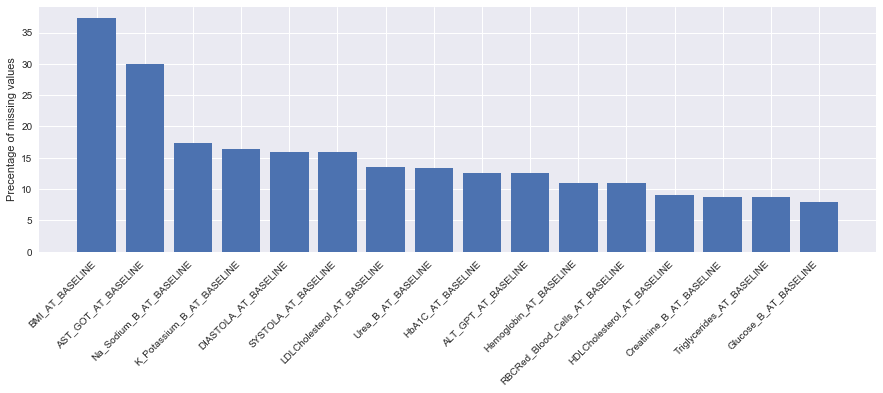

In [11]:
## Missing values
null_df = X.isnull().sum() * 100 / len(df)
null_df.sort_values(ascending=False, inplace=True)
null_df = null_df[null_df.values!=0] # Removing columns without missing values
fig, ax = plt.subplots(figsize= (15,5))
plt.style.use("seaborn")
ax.bar(null_df.index, null_df.values)
fig.autofmt_xdate(rotation=45)
ax.set_ylabel("Precentage of missing values")
print("Number of columns with missing data: {}".format(null_df.size))
plt.show()

### Imputing of data

In [12]:
## Save column names to fit after imputing
X_columns = X.columns
X_test_columns = X_test.columns

In [13]:
## Impute data (using median)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp.fit_transform(X)
X_test = imp.transform(X_test)
X = pd.DataFrame(X, columns=X_columns)
X_test = pd.DataFrame(X_test, columns=X_test_columns)

In [14]:
# X.head()

### Balancing data

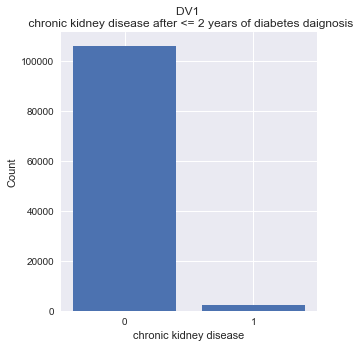

In [15]:
## Target column- before balancing
a1 = y.value_counts()

fig, (ax1) = plt.subplots(figsize = (5,5))
ax1.bar(a1.index, a1.values)
ax1.set_xticks([0,1])
ax1.set_xlabel("chronic kidney disease")
ax1.set_ylabel("Count")
ax1.set_title("DV1 \n chronic kidney disease after <= 2 years of diabetes daignosis")
plt.tight_layout()
plt.show()

In [16]:
## Over and under balancing using SMOTH
over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.5)
X,y = over.fit_resample(X,y)
X,y = under.fit_resample(X,y)

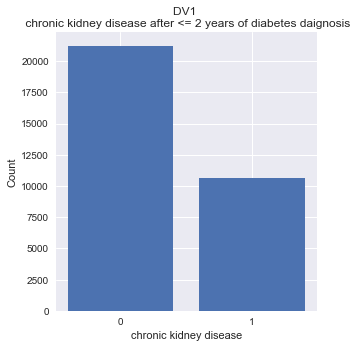

In [17]:
## Target column- after balancing

a1 = y.value_counts()

fig, (ax1) = plt.subplots(figsize = (5,5))
ax1.bar(a1.index, a1.values)
ax1.set_xticks([0,1])
ax1.set_xlabel("chronic kidney disease")
ax1.set_ylabel("Count")
ax1.set_title("DV1 \n chronic kidney disease after <= 2 years of diabetes daignosis")
plt.tight_layout()
plt.show()

In [18]:
## Correlation matrix
Numerical = ['BMI_AT_BASELINE', 'SYSTOLA_AT_BASELINE', 'DIASTOLA_AT_BASELINE',
       'Creatinine_B_AT_BASELINE', 'Albumin_B_AT_BASELINE',
       'Urea_B_AT_BASELINE', 'Glucose_B_AT_BASELINE', 'HbA1C_AT_BASELINE',
       'RBCRed_Blood_Cells_AT_BASELINE', 'Hemoglobin_AT_BASELINE',
       'Ferritin_AT_BASELINE', 'AST_GOT_AT_BASELINE', 'ALT_GPT_AT_BASELINE',
       'Bilirubin_Total_AT_BASELINE', 'Na_Sodium_B_AT_BASELINE',
       'K_Potassium_B_AT_BASELINE', 'CaCalcium_B_AT_BASELINE',
       'HDLCholesterol_AT_BASELINE', 'LDLCholesterol_AT_BASELINE',
       'Triglycerides_AT_BASELINE', 'PTH_AT_BASELINE', 'SE_HYPERTENSION',
             'SE_ISCHEMIC_MI', 'SE_CVA_TIA','SE_DEMENTIA','SE_ART_SCLE_GEN',
             'SE_TROMBOPHILIA','SE_IBD', 'AGE_AT_SDATE']
corrMatrix = pd.concat([X[Numerical],y], axis=1).corr()

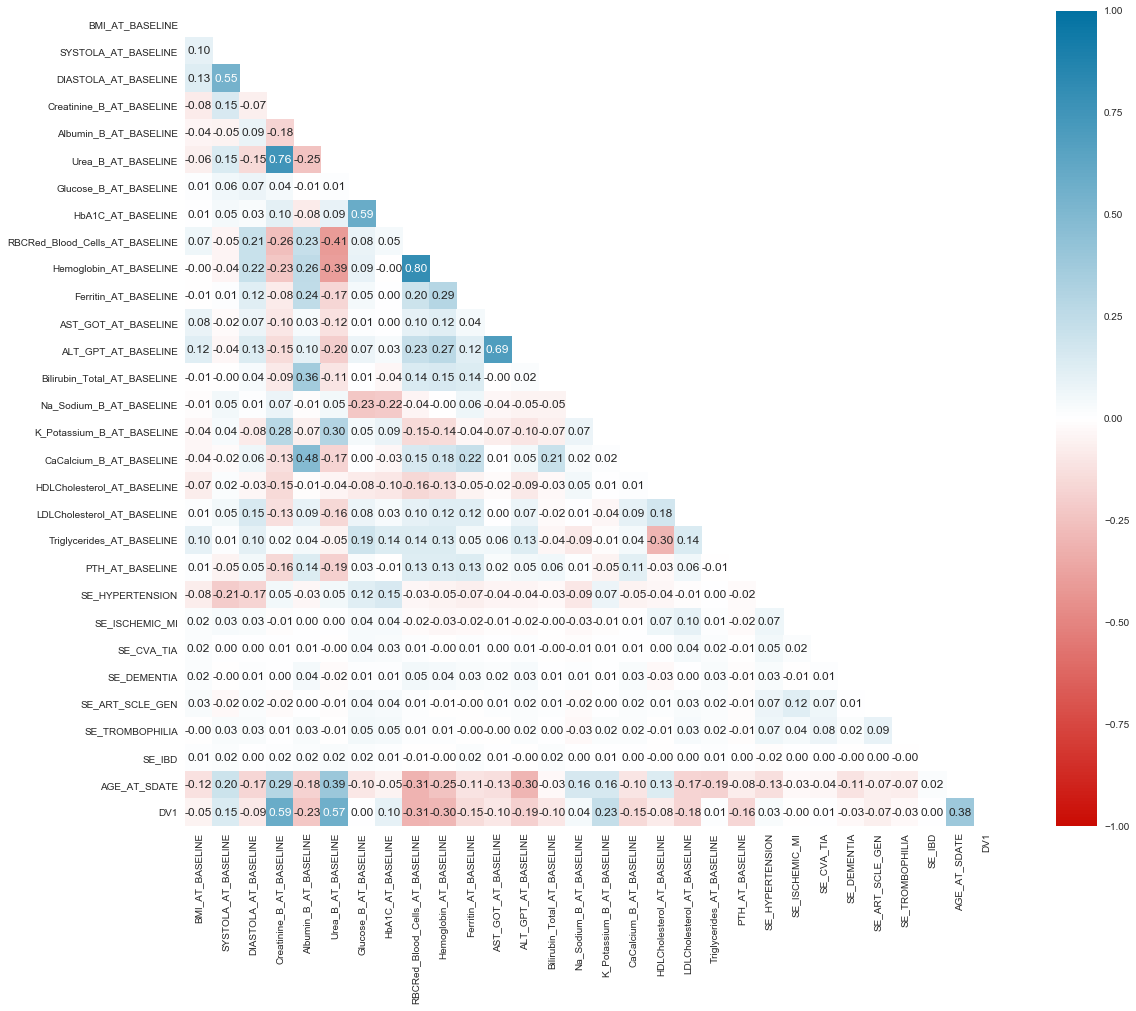

In [19]:
## heatmap
from matplotlib.colors import LinearSegmentedColormap
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corrMatrix, mask=mask, square=True,
                     cmap=LinearSegmentedColormap.from_list('rb',["r", "w", "b"],N=256),
                    annot=True, vmin=-1, vmax=1, fmt='.2f')
    # plt.savefig("corr_matrix.png")
plt.show()

# Forecasting using LightGBM

In [20]:
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

## Paramater setting (RandomSearchCV) * deactivated

In [18]:
# ## Gridsearch setting lgbm
# random_state=42

# fit_params = {"early_stopping_rounds" : 100, 
#              "eval_metric" : 'auc', 
#              "eval_set" : [(X,y)],
#              'eval_names': ['valid'],
#              'verbose': 0,
#              'categorical_feature': 'auto'}

# param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
#               'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
#               'num_leaves': sp_randint(6, 50), 
#               'min_child_samples': sp_randint(100, 500), 
#               'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#               'subsample': sp_uniform(loc=0.2, scale=0.8), 
#               'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
#               'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#               'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#               'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# #number of combinations
# n_iter = 300

# #intialize lgbm and lunch the search
# lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
# grid_search = RandomizedSearchCV(
#     estimator=lgbm_clf, param_distributions=param_test, 
#     n_iter=n_iter,
#     scoring='accuracy',
#     cv=5,
#     refit=True,
#     random_state=random_state,
#     verbose=True)

# grid_search.fit(X, y, **fit_params)
# opt_parameters =  grid_search.best_params_
# lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)

## Paramater setting (manual)

In [21]:
## manual lgbm setting
opt_parameters_manual = {'learning_rate' : 0.08,
              'n_estimators' : 1000,
              'num_leaves': 14, 
              'min_child_samples': 211, 
              'min_child_weight': 0.1,
              'subsample': 0.6196091116562037, 
              'max_depth': 6,
              'colsample_bytree': 0.5351996786275169,
              'reg_alpha': 10,
              'reg_lambda': 1}
lgbm_clf_man = lgbm.LGBMClassifier(**opt_parameters_manual)

In [22]:
## Function- model performance
def model_performance(model, subtitle) :   
    #Kfold
#     cv = KFold(n_splits=5,shuffle=False)
    cv = StratifiedKFold(n_splits=5, shuffle=False)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,val in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[val])
        precision, recall, _ = precision_recall_curve(y.iloc[val], pred_proba[:,1])
        y_real.append(y.iloc[val])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y[val], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc) 
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report (5 folds)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [23]:
## Function - Scores table
def scores_table(model, subtitle):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line = dict(color='#7D7F80'),
                    fill = dict(color='#a1c3d1'),
                    align = ['center'],
                    font = dict(size = 15)),
        cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                           np.round(df['accuracy'],3),
                           np.round(df['precision'],3),
                           np.round(df['recall'],3),
                           np.round(df['f1'],3),
                           np.round(df['roc_auc'],3)],
                   line = dict(color='#7D7F80'),
                   fill = dict(color='#EDFAFF'),
                   align = ['center'], font = dict(size = 15)))

    layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
    fig = dict(data=[trace], layout=layout)

    py.iplot(fig, filename = 'styled_table')

### Model performance on training data with cross validation- Not relevant!
Results are not relevant! We entered bias by purpose during the balancing stage. We did it in order for the model to count more for the minority group.    
Actual results should be examine with unseen data (the test data).

In [24]:
model_performance(lgbm_clf_man, 'LightGBM with over and under target balance')

In [25]:
scores_table(lgbm_clf_man, 'LightGBM with over and under target balance')

### Model performance on test data

In [26]:
## Function- model performance test data
def model_performance_testData(model, subtitle) :   
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    model.fit(X, y)
    pred_proba = model.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1])
    y_real.append(y_test)
    y_proba.append(pred_proba)
    fpr, tpr, t = roc_curve(y_test, pred_proba[:,1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc) 
    
    # Confusion matrix
    # y_pred = cross_val_predict(model, X, y, cv=5)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y_test
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba[:,1])

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report- (test data)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)

In [27]:
X_test.shape

(27095, 35)

In [28]:
model_performance_testData(lgbm_clf_man, 'LightGBM with over and under target balance')
## Should add color legend for confusion matrix on presentation